In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_75e_0.005lr_MAE_with_all_data.csv")
output_df.head()

,Unnamed: 0,Model_number,FullHad__ExpCLs,FullHad__ObsCLs,FullHad__level,1Lbb__ExpCLs,1Lbb__ObsCLs,1Lbb__level,2L0J__ExpCLs,2L0J__ObsCLs,...,Truth_ntuple,ML_input,Truth_ntuple__FILTER,DSID,AOD,PRW,EVNT,SLHA,SH_SLHA,Predicted_Final__CLs
0,859,859,1.000,1.0000,Truth,1.000,1.000,Truth,0.946,0.939,...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,9.496799e-01
1,5269,5269,1.000,1.0000,Filtered,1.000,1.000,Filtered,1.000,1.000,...,NaN,NaN,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,9.999763e-01
2,1403,1403,1.000,1.0000,Filtered,1.000,1.000,Filtered,1.000,1.000,...,NaN,NaN,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,1.000000e+00
3,2451,2451,0.640,0.4630,Truth,0.749,0.799,Truth,0.970,0.967,...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,5.382919e-01
4,7723,7723,0.193,0.0849,Truth,0.799,0.832,Truth,0.879,0.892,...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,2.809671e-08


In [2]:
# Recreating figure 4 from pMSSM paper
def recreate_figure_4b_from_pMSSM_paper(df, num_bins):
    
    m_chi_10 = df["m_chi_10"]
    valid_CLs_models = df["Predicted_Final__CLs"] > 0.05
    valid_external_constraints_models = (df["Constraints__Flavour"] == 1) & (df["Constraints__EW"] == 1)
    
    # For figure 4a, you need to split dataset into bino-, wino-, and higgsino-like LSP. Doesn't work well because numbers are too small to be smooth
    bino_like_LSP = df["LSP_type"] == 1
    wino_like_LSP = df["LSP_type"] == 2
    higgsino_like_LSP = df["LSP_type"] == 3
    
    # Create bins
    bins = np.linspace(0, 1000, num_bins + 1)
    
    # Compute number of models for each bin
    number_of_models_by_bin = []
    valid_external_constraints_by_bin = []
    allowed_models_by_bin = []
    
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin
        bin_mask = (m_chi_10 >= bins[i]) & (m_chi_10 < bins[i+1])
        valid_external_constraints_bin_mask = bin_mask & valid_external_constraints_models
        valid_CLs_and_external_constraints_bin_mask = bin_mask & valid_CLs_models & valid_external_constraints_models
        
        # Calculate number of models for this bin
        number_of_models = bin_mask.sum()
        num_valid_external_constraints_models = valid_external_constraints_bin_mask.sum()
        num_valid_CLs_and_external_constraints_models = valid_CLs_and_external_constraints_bin_mask.sum()
        
        # We only have 15% of the original dataset as we trained on the first 85%. Rescale to original to make a fair comparison
        scaled_number_of_models = number_of_models / 0.15
        scaled_num_external_constraints = num_valid_external_constraints_models / 0.15
        scaled_num_of_valid_models = num_valid_CLs_and_external_constraints_models / 0.15
        
        # Store results in array
        number_of_models_by_bin.append(scaled_number_of_models)
        valid_external_constraints_by_bin.append(scaled_num_external_constraints)
        allowed_models_by_bin.append(scaled_num_of_valid_models)
        bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(8,6))
    plt.bar(bin_centers, number_of_models_by_bin, width=(bins[1]-bins[0]), color="#d2d2d3")
    plt.bar(bin_centers, valid_external_constraints_by_bin, width=(bins[1]-bins[0]), color="#b1c5de")
    plt.bar(bin_centers, allowed_models_by_bin, width=(bins[1]-bins[0]), color="#181971")
    
    plt.title('Number of models in bins of LSP mass (scaled to match pMSSM paper)')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    
    plt.tight_layout()
    plt.legend(["All considered models", "After non-DM external constraints", "Predicted CLs > 0.05 and non-DM external constraints"])
    #plt.savefig("../plots/CLs_predictor_performance/recreate_figure_4b.pdf")
    
    return plt.gcf(), plt.gca()

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Number of models in bins of LSP mass (scaled to match pMSSM paper)'}, xlabel='m_chi_10 [GeV]', ylabel='Number of models'>)

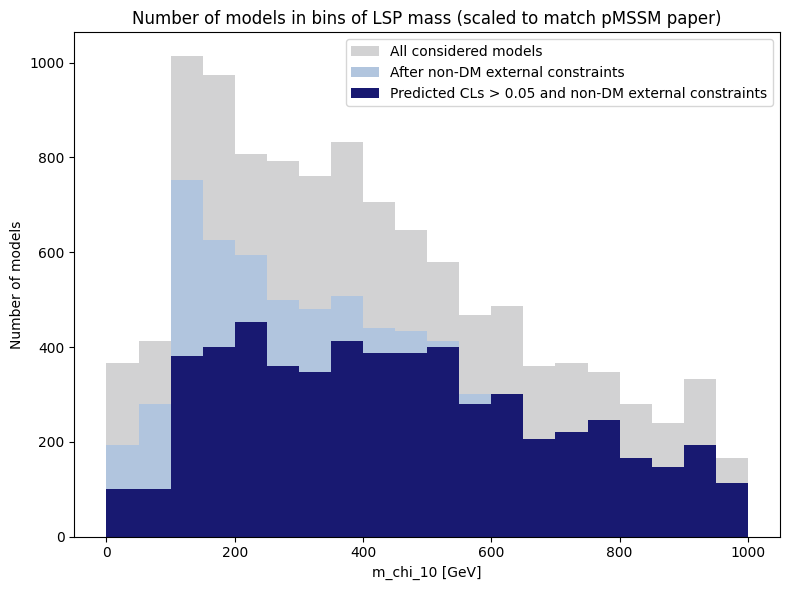

In [3]:
recreate_figure_4b_from_pMSSM_paper(output_df, 20)